# SIIM-ISIC Melanoma Classification
## Binary Classification Projektarbeit vom 22.05. bis 06.06.2023 ~ Liam Wander

- Erstellen Sie eine kurze explorative Datenanalyse zur train.csv um erste Einsichten zu gewinnen. Auffälligkeiten bitte in kurzer Form im Markdown notieren.
- Erstellen Sie ein Pytorch-Dataset, in dem Sie die Bilder und tabularen Daten zusammenfassen. Das Dataset wird drei(!) Dinge zurückgeben (das Bild, die passende Zeile aus dem Dataframe sowie das Target)
- Erstellen Sie ein Pytorch-Modell, welches ausschließlich aufgrund der Bilder klassifiziert.
- Testen Sie das Modell mit einem Sample
- Trainieren Sie das Modell und geben Sie die Accuracy sowie den F1-Score aus
- Kombinieren Sie nun tabulare Daten und Bilder: Erstellen Sie ein weiteres Pytorch-Modell welches das Bild UND die tabularen Daten verarbeiten kann. (Tipp: die Forward-Methode bekommt hier das Bild sowie die passende Zeile aus dem Dataframe übergeben, es handelt sich hier um ein Multimodales-Modell)
- Halten Sie ihr Vorgehen in Form eines (kurzen, gerne auch stichwortartigen) Protokolls im Markdown fest. Gehen Sie auch auf Probleme und Sackgassen ein!
- Beide Modelle sollen eine submission erstellen!

Tipps:

- Da hier einiges neu ist (multimodales Modell z.B.): nutzen Sie copilot, chatgpt und das Internet um herauszufinden, wie Sie das Problem angehen. 
- Das Dataset ist unbalanced, das ist ein Problem welches Sie lösen müssen
- EfficientNet dürfen auch benutzt werden, sie sind kleiner und leistungsfähiger als resnets → https://pytorch.org/hub/nvidia_deeplearningexamples_efficientnet/

https://www.statology.org/label-encoding-vs-one-hot-encoding/ OHE statt LabelEncoding, da LE eine scheinbare Gewichtung erzeugt

https://www.statology.org/dummy-variable-trap/

In [1]:
import os, torchvision
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
#from pytorch_lightning.logging import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

train_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train'
test_image_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test'


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Datenaufbereitung und Explorative Datenanalyse via ```train.csv```

In [2]:
train_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')
test_data = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/test.csv')

In [3]:
train_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
test_data[:5]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


train.csv enthält mehrere NaN-Werte in den Attributen sex, age_approx und anatom_site_general_challenge

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [7]:
train_data['sex'].unique()

array(['male', 'female', nan], dtype=object)

In [8]:
train_data['age_approx'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., nan, 80.,
       20., 85., 15., 90., 10.,  0.])

In [9]:
train_data['age_approx'].describe()

count    33058.000000
mean        48.870016
std         14.380360
min          0.000000
25%         40.000000
50%         50.000000
75%         60.000000
max         90.000000
Name: age_approx, dtype: float64

Die NaN Werte des numerischen Tupels ```age_approx``` werden aufgrund der Extremen mit dem Median ersetzt (50%=50)

In [10]:
train_data['age_approx'].fillna(50,inplace = True)

In [11]:
train_data.iloc[:,4].unique()

array(['head/neck', 'upper extremity', 'lower extremity', 'torso', nan,
       'palms/soles', 'oral/genital'], dtype=object)

In [12]:
train_data.iloc[:,4].fillna('unknown', inplace = True)
test_data.iloc[:,4].fillna('unknown', inplace = True)

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33126 non-null  float64
 4   anatom_site_general_challenge  33126 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


<AxesSubplot: >

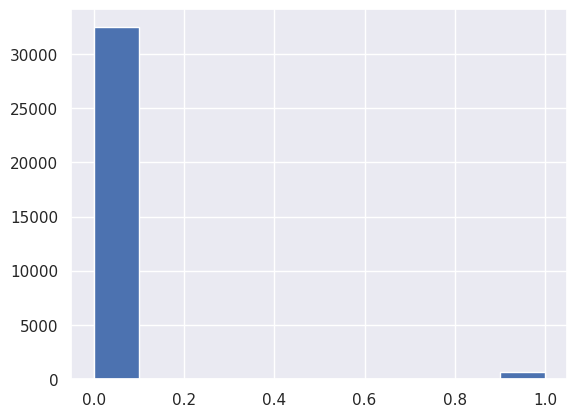

In [14]:
train_data['target'].hist()

-> Bewahrheitete Erkenntnis: moderat unausgeglichene Daten unter ```target``` im Datensatz!

Möglichkeiten zur "Korrektur":
- Nutzung anderer Performance Indikatoren
- Resampling und gewichten
    - 1. Downsampling: das Training mit einer unverhältnismäßig kleinen Teilmenge der Beispiele aus der Mehrheitsklasse.
    - 2. Bei der Gewichtung wird der Downsampling-Klasse eine Beispielgewichtung hinzugefügt, die dem Faktor entspricht, um den das Downsampling durchgeführt wurde
- Synthetische Datensätze in der Minderklasse bereitstellen

### Using Categorical Data with One Hot Encoding 

Die einzelnen Tupel sind nicht numerisch, sondern als Object gespeichert. Damit diese im weiteren Vorgehen analysierbar und verwertbar sind, bedarf es eines Label Encodings. Sprich als nächsten Schritt gilt es gleiche Objekte einer Klasse zuzuweisen.

In [15]:
# replace one sex entry in test_data with NaN to be able to perform one hot encoding hastily
test_data['sex'][0] = np.nan

/tmp/ipykernel_20/3398998241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['sex'][0] = np.nan


In [16]:
from sklearn.preprocessing import OneHotEncoder
categorical = ['sex', 'anatom_site_general_challenge']
cat_to_be_deleted = ['diagnosis', 'benign_malignant'] # sind nicht realistisch in test daten vorhanden! -> schwierig damit ein Netz zu trainieren, es sei denn man will 3 Targets haben
categorical_cols_train = []
categorical_cols_test = []

for col in categorical:
    categorical_cols_train += [f"{col[0]}_{val}" for val in train_data[col].unique()]
    
for col in categorical:
    categorical_cols_test += [f"{col[0]}_{val}" for val in test_data[col].unique()]

print(categorical_cols_train)
print(categorical_cols_test)
# create the encoder object
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# fit and transform the categorical variables.
final_train = pd.DataFrame(encoder.fit_transform(train_data[categorical]),
                          index=train_data.index, columns=categorical_cols_train)

final_train['target'] = train_data['target'] # Needed to create the correct ImageTargetDataset!
final_train.insert(0, 'image_name', train_data['image_name'])
final_train.insert(1, 'patient_id', train_data['patient_id'])

final_test = pd.DataFrame(encoder.transform(test_data[categorical]),
                            index=test_data.index, columns=categorical_cols_train)
final_test.insert(0, 'image_name', test_data['image_name'])
final_test.insert(1, 'patient_id', test_data['patient_id'])

print(final_train)
print(final_test)

['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital']
['s_nan', 's_male', 's_female', 'a_unknown', 'a_lower extremity', 'a_torso', 'a_upper extremity', 'a_head/neck', 'a_palms/soles', 'a_oral/genital']
         image_name  patient_id  s_male  s_female  s_nan  a_head/neck  \
0      ISIC_2637011  IP_7279968     0.0       1.0    0.0          1.0   
1      ISIC_0015719  IP_3075186     1.0       0.0    0.0          0.0   
2      ISIC_0052212  IP_2842074     1.0       0.0    0.0          0.0   
3      ISIC_0068279  IP_6890425     1.0       0.0    0.0          1.0   
4      ISIC_0074268  IP_8723313     1.0       0.0    0.0          0.0   
...             ...         ...     ...       ...    ...          ...   
33121  ISIC_9999134  IP_6526534     0.0       1.0    0.0          0.0   
33122  ISIC_9999320  IP_3650745     0.0       1.0    0.0          0.0   
33123  ISIC_9999515  IP_2026598     0.0       1

Nun haben wir zwei Binärkodierte Datensätze, die vielleicht mehr in einer kurzen explorativen Datenanalyse aussagen können.

/tmp/ipykernel_20/3017448773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = final_train.corr()


<AxesSubplot: >

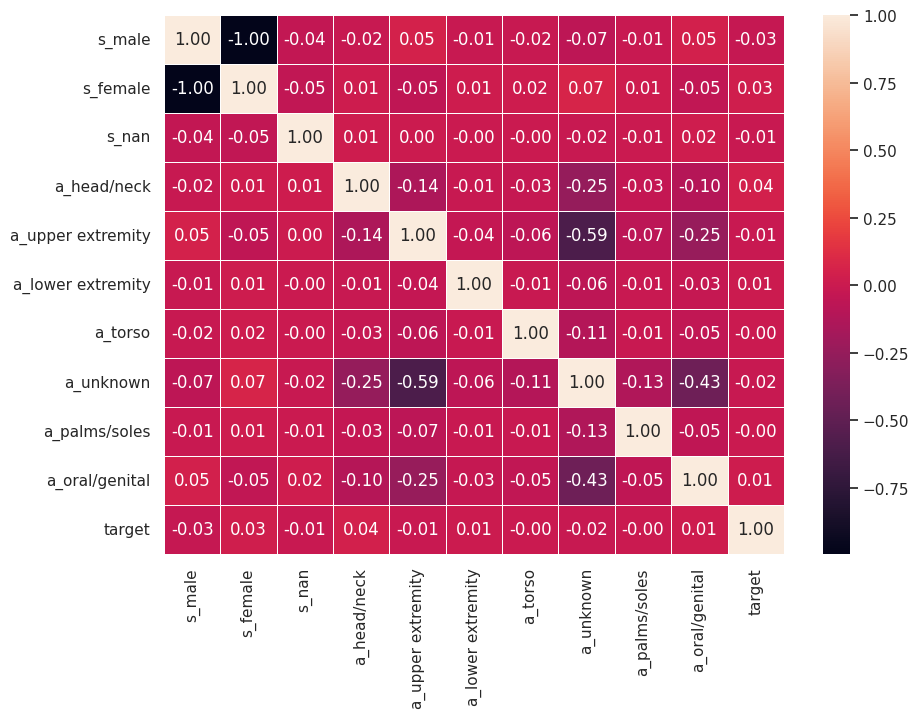

In [17]:
corr = final_train.corr()
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)

Der Körperbereich "unbekannt" korrelliert mäßig negativ mit dem Körperbereich der Oberen Extremität -> Letzteres, genauso wie der Genitalbereich scheint am häufigsten vorzukommen - bzw. wo unerwünschte Hautveränderungen bemerkt werden(?)
Außerdem: Wer kein Mann ist, ist eine Frau - und vice versa.

## Creating a DataSet that contains the Images, Data Entries and Targets
Constructing own Python Dataset, which inherits most of its features from the module Dataset:

0 torch.Size([4, 3, 300, 300]) torch.Size([4, 10]) torch.Size([4])


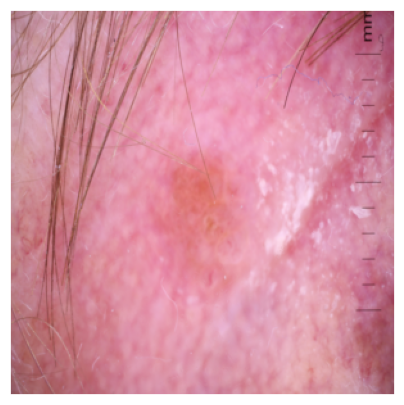

tabular_data: tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0.])
target: 0


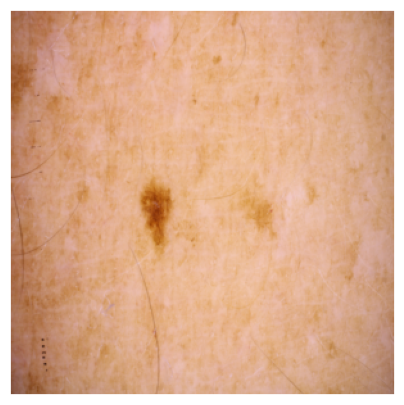

tabular_data: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
target: 0


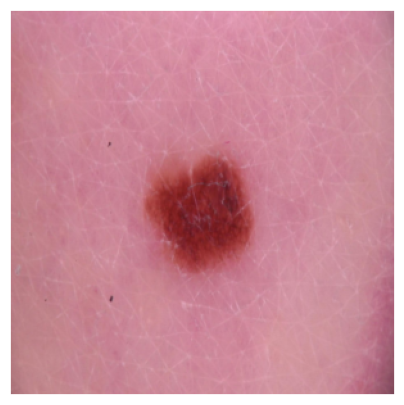

tabular_data: tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
target: 0


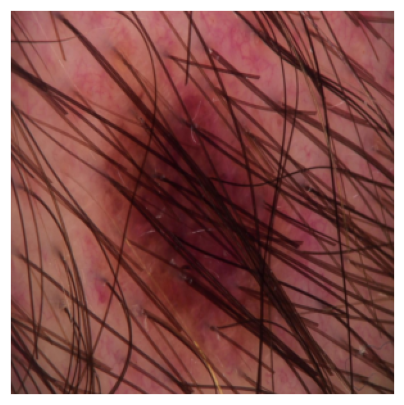

tabular_data: tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
target: 0


In [18]:
class ImageTargetDataset(Dataset):
    '''Image, Tabular and Target dataset.'''
    def __init__(self, dataframe, image_dir, transform=None):
        self.tabular_data = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        
        
        tabular_data = self.tabular_data.iloc[idx, 0:]

        y = tabular_data['target']

        image = Image.open(f"{self.image_dir}/{tabular_data['image_name']}.jpg")
        image = image.convert('RGB')
        #image = np.array(image)
        #image = image[..., :3]
        
        if self.transform:
            image = self.transform(image)
                
        #image = transforms.functional.to_tensor(image)

        tabular_data = tabular_data[['s_male', 's_female', 's_nan', 'a_head/neck', 'a_upper extremity', 'a_lower extremity', 'a_torso', 'a_unknown', 'a_palms/soles', 'a_oral/genital']]
        tabular_data = tabular_data.tolist()
        tabular_data = torch.FloatTensor(tabular_data)
        return image, tabular_data, y
    
transform=torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((300, 300), antialias=True)
])


sample = ImageTargetDataset(final_train, train_image_path, transform=transform)
sample_loader = DataLoader(sample, batch_size=4, shuffle=True, num_workers=4)

for i, (image, tabular_data, y) in enumerate(sample_loader):
    print(i, image.shape, tabular_data.shape, y.shape)
    if i == 0:
        break
        
# visualize some images
def show(imgs, figsize=(10,10), *args, **kwargs):
    '''Visualize tensors as images.'''
    grid_imgs = torchvision.utils.make_grid(imgs, *args, **kwargs)
    plt.figure(figsize=figsize)
    plt.imshow(grid_imgs.permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.show()

for i in range(4):
    image, tabular_data, y = sample[i]
    show(image, title=f"image {i}", figsize=(5,5))
    print(f"tabular_data: {tabular_data}")
    print(f"target: {y}")

Abschließend liegt ein 3-dimensionaler Datensatz vor, welcher uns je ein Bild, das dazugehörige Datum im Binärformat und das Target zurückgibt.

## Creating a PyTorch Model that classifies the Target based solely on the images